导入使用的模块

In [13]:
import operator
import math
import matplotlib.pyplot as plt

读取数据集

In [14]:
def readData(fn):
    fr=open(fn)
    lenses=[inst.strip().split('\t') for inst in fr.readlines()]
    return lenses

计算香农熵，公式为：     
$-\sum_{i=1}^{n}p(x_i)log_2    p(x_i)$

In [15]:
def calcShannonEnt(dataSet):
    numEntries=len(dataSet)
    labelCounts={}
    for featVec in dataSet:
        currentLabel=featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel]=0
        labelCounts[currentLabel]+=1
    shannonEnt=0.0
    for key in labelCounts:
        prob=float(labelCounts[key])/numEntries
        shannonEnt-=prob*math.log(prob,2)
    return shannonEnt

按给定的特征划分数据集

In [16]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

选择最好的划分方式：按不同的特征划分，取香农熵最大的划分方式

In [17]:
def choostBestSplit(dataSet):
    numFeatures=len(dataSet[0])-1
    baseEntropy=calcShannonEnt(dataSet)
    bestInfoGain=0.0
    bestFeature=-1
    for i in range(numFeatures):
        featList=[example[i] for example in dataSet]
        uniqueVals=set(featList)
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys():classCount[vote]=0
        classCount[vote]+=1
    sortedClassCount=sorted(classCount.iteritems(),key=operator.itemgetter(1),reverse=True)
    return sortedClassCount[0][0]

创建决策树

In [18]:
def CreateTree(dataSet,labels):
    classList=[example[-1] for example in dataSet]
    if classList.count(classList[0])==len(classList):
        return classList[0]
    if len(dataSet[0])==1:
        return majorityCnt(classList)
    bestFeat=choostBestSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel: {}}
    del (labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:] 
        myTree[bestFeatLabel][value] = CreateTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

绘图准备：    
* 指定图片在行内输出
* 指定最终节点框的样式
* 指定中间节点框的样式
* 指定箭头样式

In [22]:
%matplotlib  inline
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

获取叶节点数量

In [23]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[
                    key]).__name__ == 'dict': 
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

获取决策树层数

In [24]:
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[
                    key]).__name__ == 'dict': 
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

绘制节点及箭头

In [25]:
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)


绘制箭头上的文字

In [26]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)


绘制的主要工作函数

In [29]:
def plotTree(myTree, parentPt, nodeTxt):  
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0] 
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict': 
            plotTree(secondDict[key], cntrPt, str(key))
        else: 
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

绘制主函数

In [30]:
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops) 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

运行划分并绘制示意图

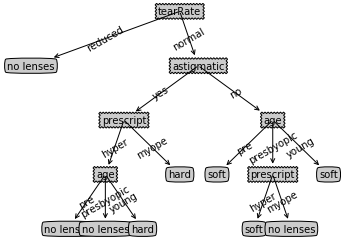

In [31]:
if __name__ == '__main__':
    data=readData("lenses.txt")
    lesesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
    lensesTree=CreateTree(data,lesesLabels)
    createPlot(lensesTree)